Simple Local Sine Tutorial
-------------------------------

This introductory tutorial demonstrates the capability to perform ensembles of
calculations in parallel using libEnsemble.

The foundation of writing libEnsemble routines is accounting for four components:

   1. The *generator function* or ``gen_f`` produces values for simulations.
   2. The *simulator function* or ``sim_f`` performs simulations based on values from the generator.
   3. The *allocation function* or ``alloc_f`` decides which of the previous two functions should be called, when.
   4. The *calling script* defines parameters for libEnsemble and these functions, then calls libEnsemble.
   
libEnsemble initializes a *manager* process and as many *worker* processes as the
user requests. The manager coordinates data-transfer between workers and assigns
each units of work, consisting of a ``gen_f`` or ``sim_f`` function to run and
accompanying data. These functions can perform their work in-line with Python or by
launching and controlling user-applications with libEnsemble's Job Controller.
Finally, workers pass results back to the manager.

For this tutorial, we'll write our ``gen_f`` and ``sim_f`` entirely in Python
without other applications. Our ``gen_f`` will produce uniform randomly-sampled
values, and our ``sim_f`` will calculate the sine of each. By default we don't
need to write a new allocation function. All generated and simulated values
alongside other parameters are stored in ``H``, the History array.

Generator function
----------------------

Let's begin by writing our `gen_f`, or generator function.

An available libEnsemble worker will call this generator function with the following parameters:

* `H`: The History array. Updated by the workers
  with `gen_f` and `sim_f` inputs and outputs, then returned to the user.
  libEnsemble passes `H` to the generator function in case the user wants to
  generate new values based on previous data.

* `persis_info`: Dictionary with worker-specific
  information. In our case this dictionary contains mechanisms called random
  streams for generating random numbers.

* `gen_specs`: Dictionary with user-defined and
  operational parameters for the `gen_f`. The user places function-specific
  parameters like boundaries and batch-sizes within the nested `user` dictionary,
  while parameters that libEnsemble depends on to operate the `gen_f` are placed
  outside `user`.

Later on, we'll populate ``gen_specs`` and ``persis_info`` in our calling script.

In [12]:
import numpy as np


def gen_random_sample(H, persis_info, gen_specs, _):

    # Pull out user parameters to perform calculations
    user_specs = gen_specs['user']

    # Get lower and upper bounds from gen_specs
    lower = user_specs['lower']
    upper = user_specs['upper']

    # Determine how many values to generate
    num = len(lower)
    batch_size = user_specs['gen_batch_size']

    # Create array of 'batch_size' zeros
    out = np.zeros(batch_size, dtype=gen_specs['out'])

    # Replace those zeros with the random numbers
    out['x'] = persis_info['rand_stream'].uniform(lower, upper, (batch_size, num))

    # Send back our output and persis_info
    return out, persis_info

Simulator function
---------------------

Simulator functions or `sim_f`s perform calculations based on values from the generator function.
The only new parameter here is `sim_specs`, which serves a similar purpose to `gen_specs`.

In [13]:
def sim_find_sine(H, persis_info, sim_specs, _):

    # Create an output array of a single zero
    out = np.zeros(1, dtype=sim_specs['out'])

    # Set the zero to the sine of the input value stored in H
    out['y'] = np.sin(H['x'])

    # Send back our output and persis_info
    return out, persis_info

Calling Script
--------------

Our calling script contains configuration for libEnsemble, the generator function, and the simulator function. It alsos performs the primary libEnsemble function call to initiate ensemble computation.

In a dictionary called `libE_specs` we specify the number of workers and the type of manager/worker communication libEnsemble will use. The communication method `local` refers to Python's Multiprocessing.

We configure the settings and specifications for our `sim_f` and `gen_f` functions in the `gen_specs` and
`sim_specs` dictionaries, which we saw previously being passed to our functions. These dictionaries also describe to libEnsemble what inputs and outputs from those functions to expect.

Recall that each worker is assigned an entry in the `persis_info` dictionary that, in this tutorial, contains a ``RandomState()`` random stream for uniform random sampling. We populate that dictionary here using a utility from
the `utils` module. Finally, we specify the circumstances where libEnsemble should stop execution in `exit_criteria`.

In [14]:
from libensemble.libE import libE
from libensemble.tools import add_unique_random_streams
from tutorial_gen import gen_random_sample
from tutorial_sim import sim_find_sine

nworkers = 4
libE_specs = {'nworkers': nworkers, 'comms': 'local'}

gen_specs = {'gen_f': gen_random_sample,        # Our generator function
             'out': [('x', float, (1,))],       # gen_f output (name, type, size).
             'user': {'lower': np.array([-3]),  # random sampling lower bound
                      'upper': np.array([3]),   # random sampling upper bound
                      'gen_batch_size': 5       # number of values gen_f will generate per call
                      }
             }

sim_specs = {'sim_f': sim_find_sine,            # Our simulator function
             'in': ['x'],                       # Input field names. 'x' from gen_f output
             'out': [('y', float)]}             # sim_f output. 'y' = sine('x')

persis_info = add_unique_random_streams({}, nworkers+1)  # Intitialize manager/workers random streams

exit_criteria = {'sim_max': 80}                 # Stop libEnsemble after 80 simulations

With specification complete, libEnsemble can be initiated via the following function call:

In [15]:
# Primary libEnsemble call. Initiates manager and worker team, begins ensemble-calculations.

H, persis_info, flag = libE(sim_specs, gen_specs, exit_criteria, persis_info,
                            libE_specs=libE_specs)

The following are a couple of lines for visualizing output data from this libEnsemble routine.

In [16]:
print([i for i in H.dtype.fields])
print(H[:16])

['allocated', 'given_time', 'given', 'gen_worker', 'returned', 'gen_time', 'y', 'sim_id', 'x', 'sim_worker']
[( True, 1.57565577e+09,  True, 3,  True, 1.57565577e+09,  0.3000904 ,  0, [ 0.30478742], 1)
 ( True, 1.57565577e+09,  True, 3,  True, 1.57565577e+09,  0.94863306,  1, [ 1.24888694], 2)
 ( True, 1.57565577e+09,  True, 3,  True, 1.57565577e+09, -0.95041621,  2, [-1.25457157], 3)
 ( True, 1.57565577e+09,  True, 3,  True, 1.57565577e+09,  0.06491994,  3, [ 0.06496563], 4)
 ( True, 1.57565577e+09,  True, 3,  True, 1.57565577e+09,  0.70605436,  4, [ 2.35768173], 1)
 ( True, 1.57565577e+09,  True, 4,  True, 1.57565577e+09,  0.33293422,  5, [ 2.80217903], 2)
 ( True, 1.57565577e+09,  True, 4,  True, 1.57565577e+09,  0.27961539,  6, [ 0.2833935 ], 3)
 ( True, 1.57565577e+09,  True, 4,  True, 1.57565577e+09,  0.30075718,  7, [ 2.83610616], 4)
 ( True, 1.57565577e+09,  True, 4,  True, 1.57565577e+09,  0.96052853,  8, [ 1.28889596], 1)
 ( True, 1.57565577e+09,  True, 4,  True, 1.57565577e+

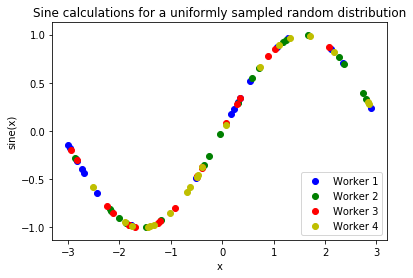

In [18]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'y', 'm', 'c', 'k', 'w']

for i in range(1, nworkers + 1):
    worker_xy = np.extract(H['sim_worker'] == i, H)
    x = [entry.tolist()[0] for entry in worker_xy['x']]
    y = [entry for entry in worker_xy['y']]
    plt.scatter(x, y, label='Worker {}'.format(i), c=colors[i-1])

plt.title('Sine calculations for a uniformly sampled random distribution')
plt.xlabel('x')
plt.ylabel('sine(x)')
plt.legend(loc='lower right')
plt.show()